In [1]:
import torch
import matplotlib.pyplot as plt
import os
import pickle

from layers import Sequential, Linear, Convolution, MaxPooling, Reshape, MSELoss, Sigmoid
from optimizer import Adam
from dataset import AffNISTDataset
from minibatch import mini_batch_training

/home/lc/.pyenv/versions/3.11.6/envs/pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load and preprocess data


In [2]:
affnist = AffNISTDataset()
if not os.path.exists("data/affnist.npz"):
    affnist.download()
X_train, X_test, y_train, y_test = affnist.load()
train_mean = X_train.mean()
train_std = X_train.std()
X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std
X_train = X_train.reshape(-1, 1, 40, 40).to('cuda' if torch.cuda.is_available() else 'cpu')
X_test = X_test.reshape(-1, 1, 40, 40).to('cuda' if torch.cuda.is_available() else 'cpu')
X_train.requires_grad = False
X_test.requires_grad = False

# Autoencoder model

In [3]:
class NNet:
    def __init__(self):
        pass
    def loss(self, y_pred, y):
        pass
    def forward(self, x):
        pass
    def backward(self):
        pass

In [4]:
class Autoencoder(NNet):
    def __init__(self, encoder, decoder, loss_obj):
        self.encoder = encoder
        self.decoder = decoder
        self.loss_obj = loss_obj
        self.Y_hat = None

    def __repr__(self):
        return f"Autoencoder(\nencoder={self.encoder}, \ndecoder={self.decoder}, \nloss={self.loss_obj})"

    def forward(self, X):
        self.Y_hat = self.decoder.forward(self.encoder.forward(X))
        return self.Y_hat

    def backward(self, Y):
        assert self.Y_hat is not None
        dY = self.loss_obj.backward(self.Y_hat, Y)
        return self.encoder.backward(self.decoder.backward(dY))

    def parameters(self):
        return self.encoder.parameters() + self.decoder.parameters()
    
    def gradients(self):
        return self.encoder.gradients() + self.decoder.gradients()
        
    def loss(self, y_hat, y):
        return self.loss_obj.forward(y_hat, y)

In [5]:
from typing import Tuple

def create_autoencoder(kernel_sizes:Tuple[int, int]=(3, 3), n_kernels:Tuple[int, int]=(4, 8)) -> Autoencoder:
    conv1_kernel_size = kernel_sizes[0]
    conv2_kernel_size = kernel_sizes[1]
    conv1_n_kernels = n_kernels[0]
    conv2_n_kernels = n_kernels[1]
    conv1_padding_keep_dims = (conv1_kernel_size - 1) // 2
    conv2_padding_keep_dims = (conv2_kernel_size - 1) // 2
    conv1 = Convolution(1, conv1_n_kernels, conv1_kernel_size, padding=conv1_padding_keep_dims)
    sigmoid1 = Sigmoid()
    pool1 = MaxPooling(2, 2)
    conv2 = Convolution(conv1_n_kernels, conv2_n_kernels, conv2_kernel_size, padding=conv2_padding_keep_dims)
    sigmoid2 = Sigmoid()
    pool2 = MaxPooling(2, 2)
    flatten = Reshape((conv2_n_kernels*10*10,))
    linear1 = Linear(conv2_n_kernels*10*10, 1*40*40//2)
    sigmoid3 = Sigmoid()
    linear2 = Linear(1*40*40//2, 1*40*40)
    unflatten = Reshape((1, 40, 40))
    mse = MSELoss()

    encoder = Sequential([conv1, sigmoid1, pool1, conv2, sigmoid2, pool2, flatten])
    decoder = Sequential([linear1, sigmoid3, linear2, unflatten])
    return Autoencoder(encoder, decoder, mse)

In [6]:
if not os.path.exists("models"):
    os.mkdir("models")

In [7]:
model = create_autoencoder((5, 5), (2, 4))
optimizer = Adam(model.parameters(), model.gradients(), lr=0.001)

In [8]:
train_losses, test_losses = mini_batch_training(
    nnet=model,
    X_train=X_train,
    y_train=X_train,
    X_test=X_test,
    y_test=X_test,
    optimizer=optimizer,
    batch_size=128,
    num_epochs=30
)

Epoch 1/30 | Train Loss: 0.5061097145080566 | Test Loss: 0.5110713839530945
Epoch 2/30 | Train Loss: 0.38554835319519043 | Test Loss: 0.38762882351875305
Epoch 3/30 | Train Loss: 0.3247765600681305 | Test Loss: 0.32878828048706055
Epoch 4/30 | Train Loss: 0.29071733355522156 | Test Loss: 0.2925008535385132
Epoch 5/30 | Train Loss: 0.26366549730300903 | Test Loss: 0.26879143714904785
Epoch 6/30 | Train Loss: 0.24449175596237183 | Test Loss: 0.25073522329330444
Epoch 7/30 | Train Loss: 0.22874070703983307 | Test Loss: 0.22684389352798462
Epoch 8/30 | Train Loss: 0.21500124037265778 | Test Loss: 0.21468855440616608
Epoch 9/30 | Train Loss: 0.20344851911067963 | Test Loss: 0.2017025649547577
Epoch 10/30 | Train Loss: 0.19273783266544342 | Test Loss: 0.19492071866989136
Epoch 11/30 | Train Loss: 0.18478524684906006 | Test Loss: 0.1852378249168396
Epoch 12/30 | Train Loss: 0.17632924020290375 | Test Loss: 0.1762170046567917
Epoch 13/30 | Train Loss: 0.16975858807563782 | Test Loss: 0.1698397

In [9]:
# SET TO TRUE TO SAVE MODEL PARAMETERS
if True:
    with open(f"models/final_autoencoder.pkl", "wb") as f:
        pickle.dump(model.parameters(), f)

In [13]:
# SET TO TRUE TO LOAD SAVED MODEL PARAMETERS
if False:
    params = model.parameters()
    saved_params = None
    with open(f"models/final_autoencoder.pkl", "rb") as f:
        saved_params = pickle.load(f)
    for p, s in zip(params, saved_params):
        p[:] = s

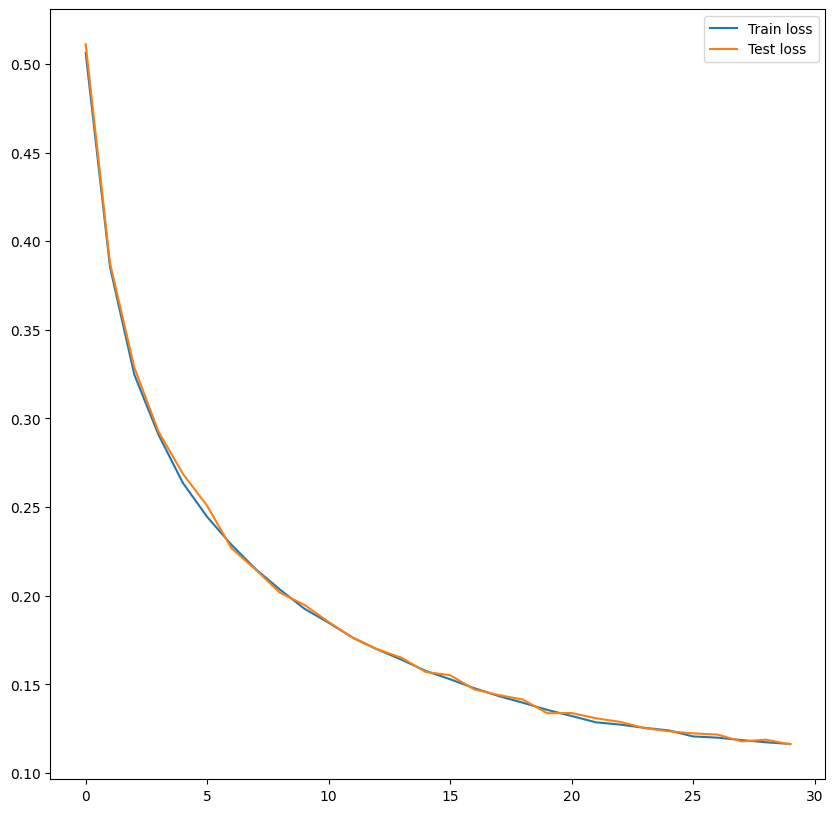

In [10]:
plt.figure(figsize=(10, 10))
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.show()
plt.close()

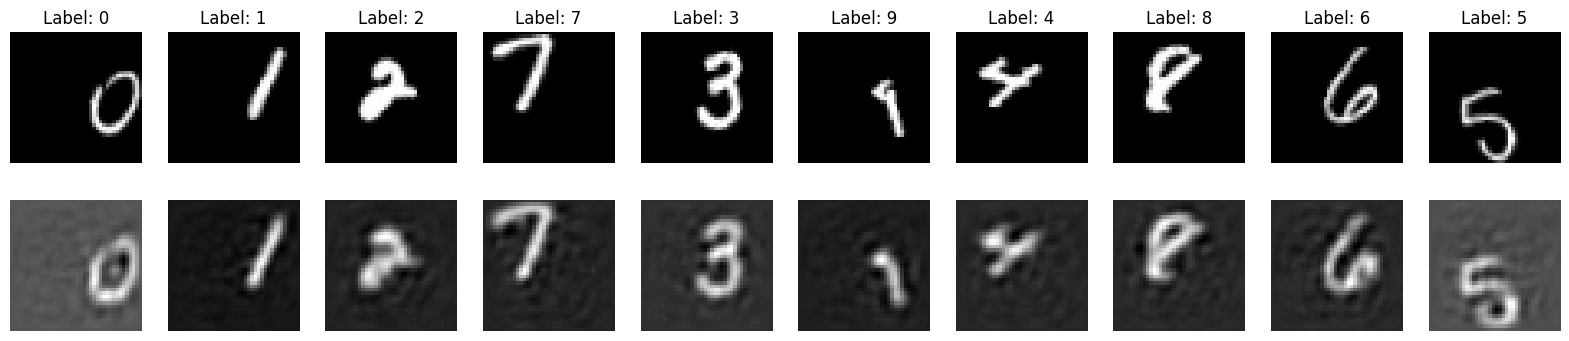

In [11]:
# Plot images of digits and reconstructions for first 10 images in test set (all 10 digits in same graph)

def plot_images_reconstructions(model, X_test, y_test):
    # Select first 10 images from test set
    X_subset = X_test[:10]
    y_subset = y_test[:10]

    # Generate reconstructions
    reconstructions = model.forward(X_subset)

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))

    # Plot original images
    for i in range(10):
        axes[0, i].imshow(X_subset[i].reshape(40, 40).cpu(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Label: {y_subset[i]}")

    # Plot reconstructed images
    for i in range(10):
        axes[1, i].imshow(reconstructions[i].reshape(40, 40).cpu(), cmap='gray')
        axes[1, i].axis('off')

    # Save the figure
    plt.show()
    plt.close()

plot_images_reconstructions(model, X_test, y_test)

2023-12-15 04:58:39.840425: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-15 04:58:39.842808: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 04:58:39.869136: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 04:58:39.869180: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 04:58:39.869214: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

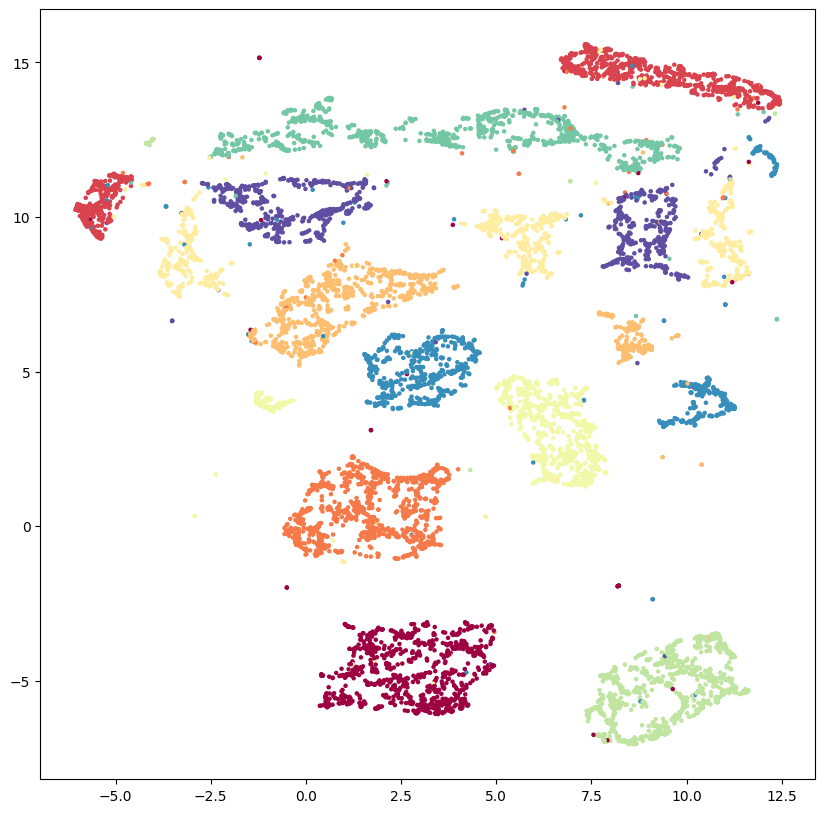

In [14]:
from umap import UMAP

encoder = model.encoder
latent_space = encoder.forward(X_test)
umap = UMAP()
umap.fit(latent_space.detach().numpy(), y_test)
plt.figure(figsize=(10, 10))
plt.scatter(umap.embedding_[:, 0], umap.embedding_[:, 1], c=y_test, cmap='Spectral', s=5)
plt.show()
plt.close()

# Plot a few feature maps

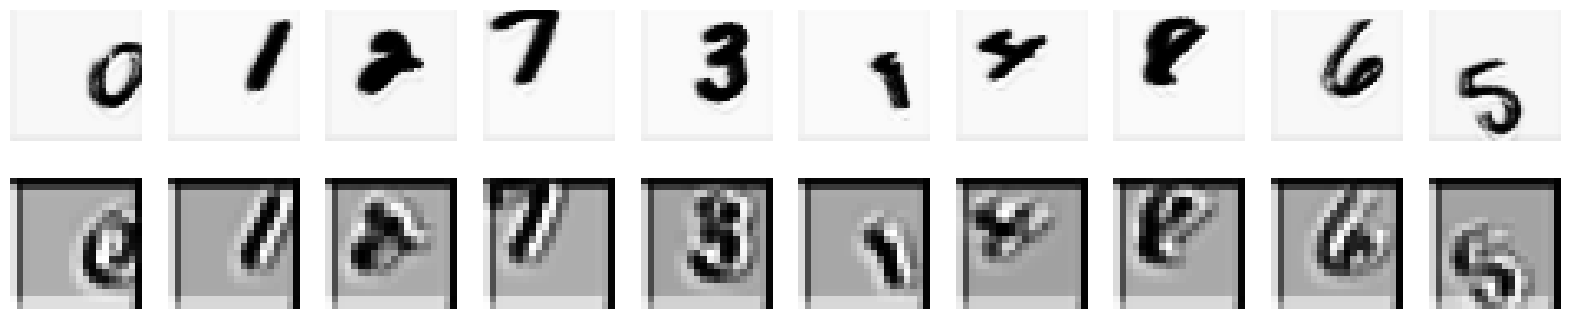

In [16]:
fm_model_1 = Sequential(model.encoder.layers[:2])
fm_model_2 = Sequential(model.encoder.layers[:5])

fm_1 = fm_model_1.forward(X_test[:10])
fm_2 = fm_model_2.forward(X_test[:10])

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))
for i in range(10):
    axes[0, i].imshow(fm_1[i][0].cpu(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(fm_2[i][0].cpu(), cmap='gray')
    axes[1, i].axis('off')
plt.show()

# Plot all kernels

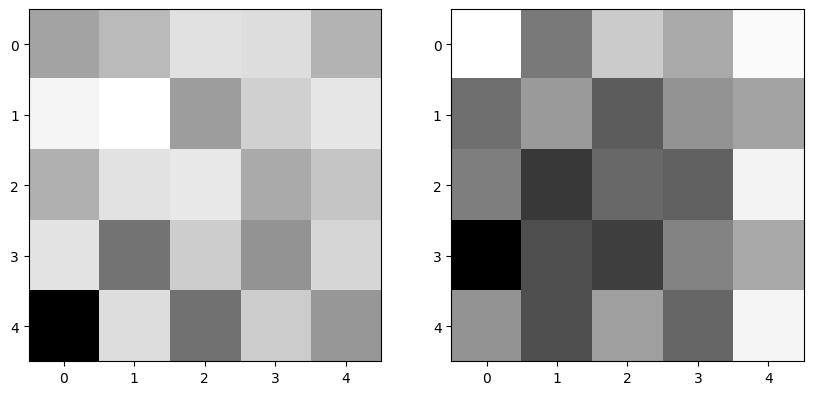

In [27]:
# Plot all kernels in first convolutional layer
conv1 = model.encoder.layers[0]
conv1_weights = conv1.W.detach().cpu()
fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
for i in range(2):
    axes[i].imshow(conv1_weights[i][0], cmap='gray')

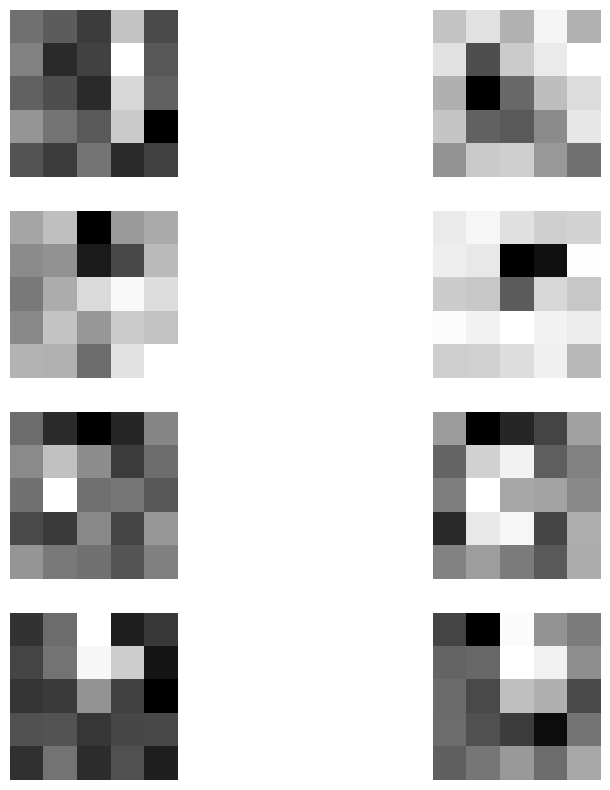

In [23]:
# Plot all kernels in second convolutional layer
conv2 = model.encoder.layers[3]
conv2_weights = conv2.W.detach().cpu()
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
for i in range(4):
    for j in range(2):
        axes[i, j].imshow(conv2_weights[i][j], cmap='gray')
        axes[i, j].axis('off')

# Train a classifier

## On autoenc embeddings

### Train a regular autoencoder

In [34]:
# Train a regular autoencoder
reshape1 = Reshape((1*40*40,))
l1 = Linear(1*40*40, 1*40*40//4) # We set the latent space to be 1/4 the size of the original image, just like in the convolutional autoencoder
sigmoid1 = Sigmoid()
l2 = Linear(1*40*40//4, 1*40*40)
reshape2 = Reshape((1, 40, 40))
loss_obj = MSELoss()
simple_encoder = Sequential([reshape1, l1, sigmoid1])
simple_decoder = Sequential([l2, reshape2])
simple_model = Autoencoder(simple_encoder, simple_decoder, loss_obj)
simple_optimizer = Adam(simple_model.parameters(), simple_model.gradients(), lr=0.001)
simple_train_losses, simple_test_losses = mini_batch_training(
    nnet=simple_model,
    X_train=X_train,
    y_train=X_train,
    X_test=X_test,
    y_test=X_test,
    optimizer=simple_optimizer,
    batch_size=128,
    num_epochs=7
)

Epoch 1/7 | Train Loss: 0.15420646965503693 | Test Loss: 0.15217344462871552
Epoch 2/7 | Train Loss: 0.09673376381397247 | Test Loss: 0.10014806687831879
Epoch 3/7 | Train Loss: 0.07538946717977524 | Test Loss: 0.07703789323568344
Epoch 4/7 | Train Loss: 0.06394748389720917 | Test Loss: 0.06711757183074951
Epoch 5/7 | Train Loss: 0.05683104321360588 | Test Loss: 0.058812979608774185
Epoch 6/7 | Train Loss: 0.051099326461553574 | Test Loss: 0.052973296493291855
Epoch 7/7 | Train Loss: 0.04829692468047142 | Test Loss: 0.04899728670716286


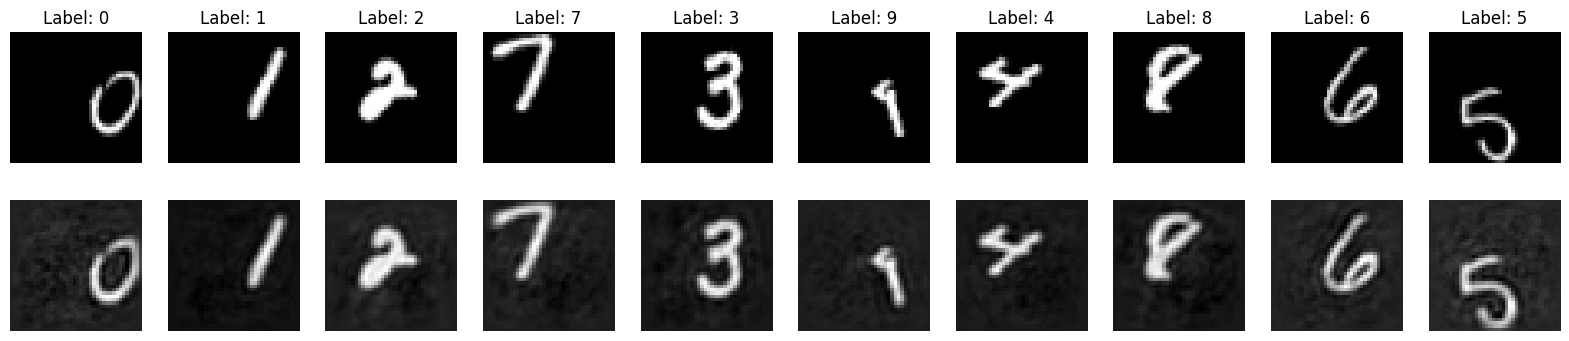

In [35]:
plot_images_reconstructions(simple_model, X_test, y_test)

In [146]:
from layers import ReLU, SoftmaxCrossEntropyLoss
from optimizer import SGD
from minibatch import batched_forward, mini_batch_training

l1 = Linear(1*40*40//4, 1*40*40//2)
relu1 = ReLU()
l2 = Linear(1*40*40//2, 10)
softmax = SoftmaxCrossEntropyLoss()

class SimpleClassifier(NNet):
    def __init__(self):
        self.sequential = Sequential([l1, relu1, l2, softmax])
        super().__init__()
    
    def forward(self, X):
        self.Y = self.sequential.forward(X)
        return self.Y

    def backward(self, Y):
        return self.sequential.backward(Y)
    
    def parameters(self):
        return self.sequential.parameters()
    
    def gradients(self):
        return self.sequential.gradients()
    
    def loss(self, y_hat, y):
        return softmax.loss(y_hat, y)
    
nnet = SimpleClassifier()
optimizer = Adam(nnet.parameters(), nnet.gradients(), lr=0.001)

In [147]:
X_train_simple_embedding = batched_forward(simple_model.encoder, X_train, 128)
X_test_simple_embedding = batched_forward(simple_model.encoder, X_test, 128)

mean_X_train_simple_embedding = X_train_simple_embedding.mean(dim=0)
std_X_train_simple_embedding = X_train_simple_embedding.std(dim=0)

X_train_simple_embedding = (X_train_simple_embedding - mean_X_train_simple_embedding) / std_X_train_simple_embedding
X_test_simple_embedding = (X_test_simple_embedding - mean_X_train_simple_embedding) / std_X_train_simple_embedding

y_train_1hot = torch.zeros((len(y_train), 10))
y_train_1hot[torch.arange(len(y_train)), y_train] = 1
y_test_1hot = torch.zeros((len(y_test), 10))
y_test_1hot[torch.arange(len(y_test)), y_test] = 1

In [148]:
y_test_1hot

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

In [149]:
from importlib import reload
import minibatch as mb
reload(mb)

train_losses, test_losses = mb.mini_batch_training(
    nnet=nnet,
    X_train=X_train_simple_embedding,
    y_train=y_train_1hot,
    X_test=X_test_simple_embedding,
    y_test=y_test_1hot,
    optimizer=optimizer,
    batch_size=128,
    num_epochs=20
)

Epoch 1/20 | Train Loss: 1.9477730989456177 | Test Loss: 1.976403832435608
Epoch 2/20 | Train Loss: 1.7699787616729736 | Test Loss: 1.8693263530731201
Epoch 3/20 | Train Loss: 1.6855131387710571 | Test Loss: 1.7899128198623657
Epoch 4/20 | Train Loss: 1.6322681903839111 | Test Loss: 1.7746573686599731
Epoch 5/20 | Train Loss: 1.585166573524475 | Test Loss: 1.7279001474380493
Epoch 6/20 | Train Loss: 1.5546073913574219 | Test Loss: 1.7345681190490723
Epoch 7/20 | Train Loss: 1.536923885345459 | Test Loss: 1.7392373085021973
Epoch 8/20 | Train Loss: 1.516395926475525 | Test Loss: 1.7355154752731323
Epoch 9/20 | Train Loss: 1.500999927520752 | Test Loss: 1.7218316793441772
Epoch 10/20 | Train Loss: 1.4893537759780884 | Test Loss: 1.7155365943908691
Epoch 11/20 | Train Loss: 1.484924077987671 | Test Loss: 1.6861974000930786
Epoch 12/20 | Train Loss: 1.4762316942214966 | Test Loss: 1.6982274055480957
Epoch 13/20 | Train Loss: 1.4991283416748047 | Test Loss: 1.7156747579574585
Epoch 14/20 | 

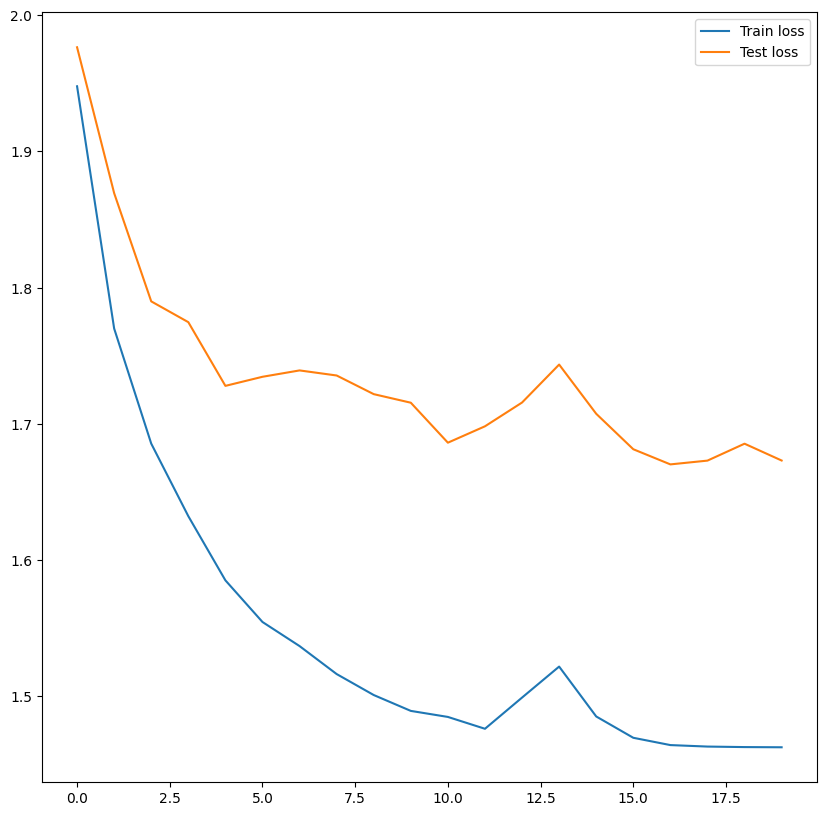

In [150]:
# Plot train and test losses
plt.figure(figsize=(10, 10))
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.show()
plt.close()

In [151]:
#Classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
Y_hat = batched_forward(nnet, X_test_simple_embedding, 128)
y_hat = Y_hat.argmax(dim=1)

In [152]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       980
           1       0.92      0.97      0.94      1135
           2       0.82      0.75      0.78      1032
           3       0.75      0.77      0.76      1010
           4       0.77      0.75      0.76       982
           5       0.71      0.73      0.72       892
           6       0.79      0.79      0.79       958
           7       0.83      0.80      0.82      1028
           8       0.76      0.73      0.74       974
           9       0.67      0.72      0.69      1009

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



## On conv autoenc embeddings

In [37]:
from layers import ReLU, SoftmaxCrossEntropyLoss
from optimizer import SGD
from minibatch import batched_forward, mini_batch_training

reshape1 = Reshape((4*10*10,))
l1 = Linear(4*10*10, 4*10*10*3)
relu1 = ReLU()
l2 = Linear(4*10*10*3, 10)
softmax = SoftmaxCrossEntropyLoss()

class ConvEmbClassifier(NNet):
    def __init__(self):
        self.sequential = Sequential([reshape1, l1, relu1, l2, softmax])
        super().__init__()
    
    def forward(self, X):
        self.Y = self.sequential.forward(X)
        return self.Y

    def backward(self, Y):
        return self.sequential.backward(Y)
    
    def parameters(self):
        return self.sequential.parameters()
    
    def gradients(self):
        return self.sequential.gradients()
    
    def loss(self, y_hat, y):
        return softmax.loss(y_hat, y)
    
nnet_convemb = ConvEmbClassifier()
optimizer_convemb = Adam(nnet_convemb.parameters(), nnet_convemb.gradients(), lr=0.001)
conv_encoder = model.encoder

In [24]:
X_train_convemb = batched_forward(conv_encoder, X_train, 2048)

In [25]:
X_test_convemb = batched_forward(conv_encoder, X_test, 2048)

In [26]:
X_train_convemb.shape

torch.Size([50000, 400])

In [27]:
y_train_1hot = torch.zeros((len(y_train), 10))
y_train_1hot[torch.arange(len(y_train)), y_train] = 1
y_test_1hot = torch.zeros((len(y_test), 10))
y_test_1hot[torch.arange(len(y_test)), y_test] = 1

In [38]:
train_losses, test_losses = mini_batch_training(
    nnet=nnet_convemb,
    X_train=X_train_convemb,
    y_train=y_train_1hot,
    X_test=X_test_convemb,
    y_test=y_test_1hot,
    optimizer=optimizer_convemb,
    batch_size=128,
    num_epochs=30
)

Epoch 1/30 | Train Loss: 2.2448203563690186 | Test Loss: 2.2439024448394775
Epoch 2/30 | Train Loss: 2.177109718322754 | Test Loss: 2.181201457977295
Epoch 3/30 | Train Loss: 2.0961291790008545 | Test Loss: 2.096503973007202
Epoch 4/30 | Train Loss: 2.037503719329834 | Test Loss: 2.05143666267395
Epoch 5/30 | Train Loss: 1.9839955568313599 | Test Loss: 1.9998506307601929
Epoch 6/30 | Train Loss: 1.953697681427002 | Test Loss: 1.9572243690490723
Epoch 7/30 | Train Loss: 1.920091986656189 | Test Loss: 1.9254450798034668
Epoch 8/30 | Train Loss: 1.8962777853012085 | Test Loss: 1.9108957052230835
Epoch 9/30 | Train Loss: 1.8817318677902222 | Test Loss: 1.899053931236267
Epoch 10/30 | Train Loss: 1.850821852684021 | Test Loss: 1.8650288581848145
Epoch 11/30 | Train Loss: 1.8426443338394165 | Test Loss: 1.8451206684112549
Epoch 12/30 | Train Loss: 1.817509412765503 | Test Loss: 1.8159714937210083
Epoch 13/30 | Train Loss: 1.807892918586731 | Test Loss: 1.827048659324646
Epoch 14/30 | Train L

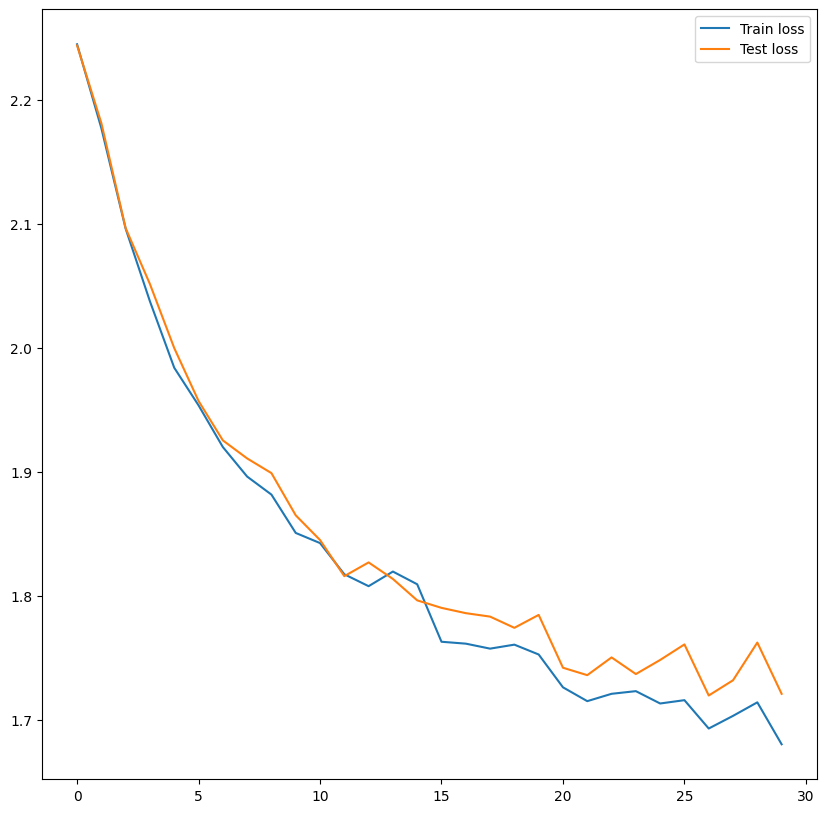

In [40]:
# Plot train and test losses
plt.figure(figsize=(10, 10))
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.show()
plt.close()

In [41]:
#Classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
Y_hat = batched_forward(nnet_convemb, X_test_convemb, 2048)
y_hat = Y_hat.argmax(dim=1)

In [42]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       980
           1       0.86      0.98      0.92      1135
           2       0.87      0.79      0.83      1032
           3       0.75      0.83      0.79      1010
           4       0.79      0.79      0.79       982
           5       0.63      0.87      0.73       892
           6       0.89      0.83      0.86       958
           7       0.87      0.80      0.83      1028
           8       0.85      0.59      0.70       974
           9       0.74      0.74      0.74      1009

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



In [43]:
train_losses_2, test_losses_2 = mini_batch_training(
    nnet=nnet_convemb,
    X_train=X_train_convemb,
    y_train=y_train_1hot,
    X_test=X_test_convemb,
    y_test=y_test_1hot,
    optimizer=optimizer_convemb,
    batch_size=128,
    num_epochs=15
)

Epoch 1/15 | Train Loss: 1.6888792514801025 | Test Loss: 1.7367510795593262
Epoch 2/15 | Train Loss: 1.682564616203308 | Test Loss: 1.7126893997192383
Epoch 3/15 | Train Loss: 1.6783466339111328 | Test Loss: 1.7210450172424316
Epoch 4/15 | Train Loss: 1.6706597805023193 | Test Loss: 1.6958441734313965
Epoch 5/15 | Train Loss: 1.6665316820144653 | Test Loss: 1.6919528245925903
Epoch 6/15 | Train Loss: 1.668763279914856 | Test Loss: 1.7079181671142578
Epoch 7/15 | Train Loss: 1.6516611576080322 | Test Loss: 1.7004956007003784
Epoch 8/15 | Train Loss: 1.675842046737671 | Test Loss: 1.698578119277954
Epoch 9/15 | Train Loss: 1.6723586320877075 | Test Loss: 1.710816740989685
Epoch 10/15 | Train Loss: 1.6504719257354736 | Test Loss: 1.7078005075454712
Epoch 11/15 | Train Loss: 1.6731586456298828 | Test Loss: 1.712993860244751
Epoch 12/15 | Train Loss: 1.6622999906539917 | Test Loss: 1.707449197769165
Epoch 13/15 | Train Loss: 1.6574780941009521 | Test Loss: 1.6977112293243408
Epoch 14/15 | T

In [45]:
train_losses_3, test_losses_3 = mini_batch_training(
    nnet=nnet_convemb,
    X_train=X_train_convemb,
    y_train=y_train_1hot,
    X_test=X_test_convemb,
    y_test=y_test_1hot,
    optimizer=optimizer_convemb,
    batch_size=128,
    num_epochs=15
)

Epoch 1/15 | Train Loss: 1.631648302078247 | Test Loss: 1.6856518983840942
Epoch 2/15 | Train Loss: 1.6300525665283203 | Test Loss: 1.6788932085037231
Epoch 3/15 | Train Loss: 1.6540695428848267 | Test Loss: 1.6984316110610962
Epoch 4/15 | Train Loss: 1.6306952238082886 | Test Loss: 1.687429428100586
Epoch 5/15 | Train Loss: 1.6459349393844604 | Test Loss: 1.6976934671401978
Epoch 6/15 | Train Loss: 1.6240642070770264 | Test Loss: 1.6731090545654297
Epoch 7/15 | Train Loss: 1.6379531621932983 | Test Loss: 1.6712286472320557
Epoch 8/15 | Train Loss: 1.6241198778152466 | Test Loss: 1.662783145904541
Epoch 9/15 | Train Loss: 1.62943434715271 | Test Loss: 1.6816649436950684
Epoch 10/15 | Train Loss: 1.6105437278747559 | Test Loss: 1.6802263259887695
Epoch 11/15 | Train Loss: 1.6141257286071777 | Test Loss: 1.6578936576843262
Epoch 12/15 | Train Loss: 1.6070173978805542 | Test Loss: 1.6707013845443726
Epoch 13/15 | Train Loss: 1.6160866022109985 | Test Loss: 1.6698930263519287
Epoch 14/15 |

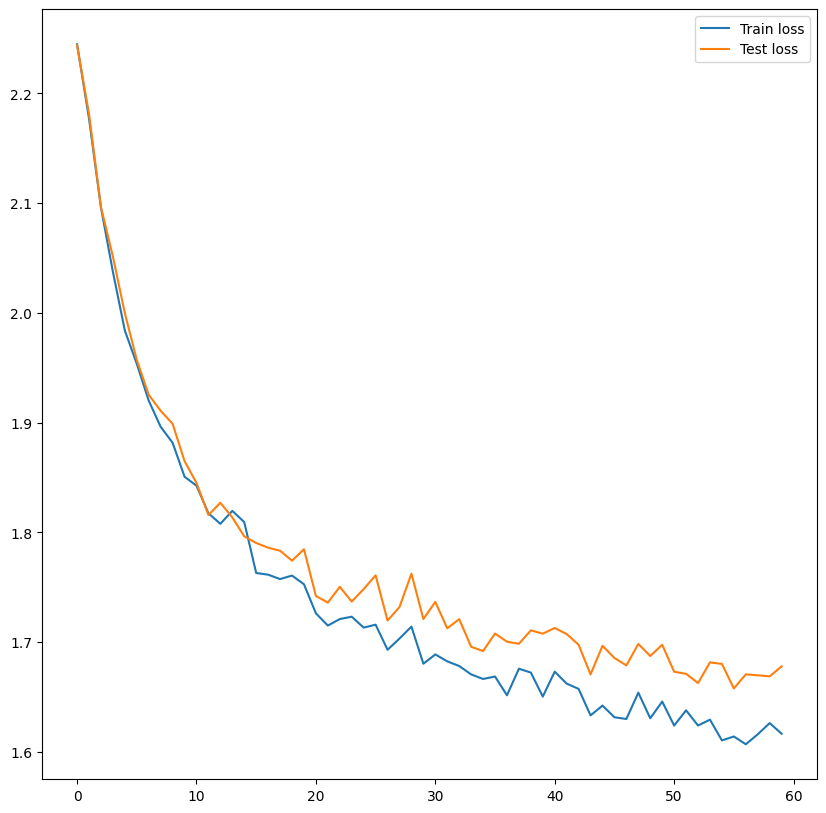

In [46]:
# Plot train and test losses
plt.figure(figsize=(10, 10))
plt.plot(train_losses + train_losses_2 + train_losses_3, label="Train loss")
plt.plot(test_losses + test_losses_2 + test_losses_3, label="Test loss")
plt.legend()
plt.show()
plt.close()

In [47]:
#Classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
Y_hat2 = batched_forward(nnet_convemb, X_test_convemb, 2048)
y_hat2 = Y_hat2.argmax(dim=1)

In [49]:
print(classification_report(y_test, y_hat2))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       980
           1       0.97      0.94      0.95      1135
           2       0.89      0.81      0.85      1032
           3       0.82      0.85      0.84      1010
           4       0.75      0.86      0.80       982
           5       0.83      0.78      0.80       892
           6       0.88      0.86      0.87       958
           7       0.93      0.78      0.85      1028
           8       0.73      0.80      0.76       974
           9       0.68      0.82      0.74      1009

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.84     10000
weighted avg       0.84      0.83      0.84     10000

